In [1]:
import cv2
import numpy as np
import os
import scipy.io as sio
from extractors import Extractors
from random import randint
from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
import random

DATASET_FOLDER = "MSRC_ObjCategImageDatabase_v2"
DESCRIPTOR_FOLDER = "descriptors"

In [2]:
class DescriptorExtractor:
    def __init__(self, dataset_folder: str, descriptor_folder: str):
        self.DATASET_FOLDER = dataset_folder
        self.DESCRIPTOR_FOLDER = descriptor_folder

    def extract(self, extract_method=Extractors.extract_rgb):
        descriptor_paths = {
            Extractors.extract_rgb: os.path.join(self.DESCRIPTOR_FOLDER, 'globalRGBhisto'),
            Extractors.extract_random: os.path.join(self.DESCRIPTOR_FOLDER, 'random')
        }

        if extract_method not in descriptor_paths:
            raise ValueError(f"Invalid extract_method: {extract_method}")

        descriptor_path = descriptor_paths[extract_method]
        if not os.path.exists(descriptor_path):
            os.makedirs(descriptor_path, exist_ok=True)
        for filename in os.listdir(os.path.join(self.DATASET_FOLDER, 'Images')):
            if filename.endswith(".bmp"):
                img_path = os.path.join(self.DATASET_FOLDER, 'Images', filename)
                img = cv2.imread(img_path).astype(np.float64) / 255.0  # Normalize the image
                fout = os.path.join(descriptor_path, filename).replace('.bmp', '.npy')
                F = extract_method(img)        
                np.save(fout, F)

    def get_image_descriptor_mapping(self, descriptor_type='globalRGBhisto') -> Dict[str, np.ndarray]:
        descriptor_path = os.path.join(self.DESCRIPTOR_FOLDER, descriptor_type)
        img_to_descriptor = {}
        for filename in os.listdir(descriptor_path):
            if filename.endswith('.npy'):
                img_path = os.path.join(self.DATASET_FOLDER, 'Images', filename.replace('.npy', '.bmp'))
                descriptor_data = np.load(os.path.join(descriptor_path, filename))
                img_to_descriptor[img_path] = descriptor_data
        return img_to_descriptor

In [3]:
class ImageRetriever:
    def __init__(self, img_desc_dict: Dict[str, np.ndarray]):
        self.img_desc_dict = img_desc_dict

    def cvpr_compare(self, F1, F2):
        # This function should compare F1 to F2 - i.e. compute the distance
        # between the two descriptors
        # For now it just returns a random number
        # dst = np.random.rand()
        dst = np.linalg.norm(F1 - F2)
        return dst

    def compute_distance(self, query_img: str, metric="l1") -> List[Tuple[float, str]]:
        # Compute the distance between the query and all other descriptors
        dst = []
        query_img_desc = self.img_desc_dict[query_img]
        
        for img_path, candidate_desc in self.img_desc_dict.items():
            if img_path != query_img:  # Skip the query image itself
                distance = self.cvpr_compare(query_img_desc, candidate_desc)
                dst.append((distance, img_path))
        
        dst.sort(key=lambda x: x[0])
        return dst

    def retrieve(self, query_img: str, number: int = 10) -> list:
        # Compute distances
        distances = self.compute_distance(query_img)
        
        # Get the top 'number' similar images
        top_similar_images = distances[:number]
        
        # Display the query image and top similar images
        ImageRetriever.display_images(query_img, top_similar_images, number)
        
        # Return the list of top similar images
        return [img_path for _, img_path in top_similar_images]

    @staticmethod
    def display_images(query_img: str, top_similar_images: list, number: int):
        fig, axes = plt.subplots(1, number + 1, figsize=(20, 5))
        distances = []
        # Display the query image
        query_img_data = cv2.imread(query_img)
        query_img_data = cv2.cvtColor(query_img_data, cv2.COLOR_BGR2RGB)
        axes[0].imshow(query_img_data)
        axes[0].set_title('Query Image')
        axes[0].axis('off')
        
        # Display the top similar images
        for ax, (distance, img_path) in zip(axes[1:], top_similar_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.axis('off')
            distances.append(distance)
        plt.show()
        print("Distances: \n", distances)


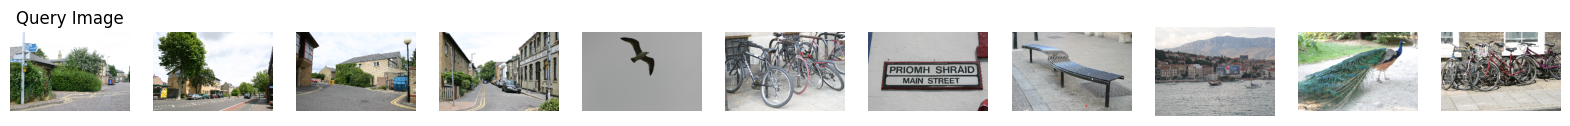

Distances: 
 [np.float64(0.025634170552487272), np.float64(0.02696123018888828), np.float64(0.03798426417921464), np.float64(0.03845338819861194), np.float64(0.03931127519490597), np.float64(0.040645138275189785), np.float64(0.041123328151011114), np.float64(0.043458030491134336), np.float64(0.044287795696122144), np.float64(0.04642425368115436)]


In [4]:
# extract Descriptors
extractor = DescriptorExtractor(DATASET_FOLDER, DESCRIPTOR_FOLDER)
extractor.extract()
img2descriptors = extractor.get_image_descriptor_mapping()

# retrieve based on the img2descriptors dict
retriever = ImageRetriever(img2descriptors) 
random_image = random.choice(list(img2descriptors.keys()))
similar_images = retriever.retrieve(random_image)